In [2]:
import pandas as pd
import glob
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
columns  = [["Robot_{}_x".format(str(i)), "Robot_{}_y".format(str(i)), "Robot_{}_z".format(str(i)), "Robot_{}_phi".format(str(i))] for i in range(20)]
columns  = [item for sublist in columns for item in sublist]
print(columns)

['Robot_0_x', 'Robot_0_y', 'Robot_0_z', 'Robot_0_phi', 'Robot_1_x', 'Robot_1_y', 'Robot_1_z', 'Robot_1_phi', 'Robot_2_x', 'Robot_2_y', 'Robot_2_z', 'Robot_2_phi', 'Robot_3_x', 'Robot_3_y', 'Robot_3_z', 'Robot_3_phi', 'Robot_4_x', 'Robot_4_y', 'Robot_4_z', 'Robot_4_phi', 'Robot_5_x', 'Robot_5_y', 'Robot_5_z', 'Robot_5_phi', 'Robot_6_x', 'Robot_6_y', 'Robot_6_z', 'Robot_6_phi', 'Robot_7_x', 'Robot_7_y', 'Robot_7_z', 'Robot_7_phi', 'Robot_8_x', 'Robot_8_y', 'Robot_8_z', 'Robot_8_phi', 'Robot_9_x', 'Robot_9_y', 'Robot_9_z', 'Robot_9_phi', 'Robot_10_x', 'Robot_10_y', 'Robot_10_z', 'Robot_10_phi', 'Robot_11_x', 'Robot_11_y', 'Robot_11_z', 'Robot_11_phi', 'Robot_12_x', 'Robot_12_y', 'Robot_12_z', 'Robot_12_phi', 'Robot_13_x', 'Robot_13_y', 'Robot_13_z', 'Robot_13_phi', 'Robot_14_x', 'Robot_14_y', 'Robot_14_z', 'Robot_14_phi', 'Robot_15_x', 'Robot_15_y', 'Robot_15_z', 'Robot_15_phi', 'Robot_16_x', 'Robot_16_y', 'Robot_16_z', 'Robot_16_phi', 'Robot_17_x', 'Robot_17_y', 'Robot_17_z', 'Robot_17_p

In [5]:
txt_files = glob.glob("/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/*data.txt")
print(txt_files)

['/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/influence_param_1.614285714285714_sensing_param_25.714285714285715_attract_0_speed_up_1_no_fish_8_spread_2000_time_1750_data.txt', '/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/influence_param_1.614285714285714_sensing_param_15.0_attract_0_speed_up_0_no_fish_8_spread_2000_time_1750_data.txt', '/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/influence_param_3.5_sensing_param_57.857142857142854_attract_0_speed_up_1_no_fish_8_spread_2000_time_1750_data.txt', '/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/influence_param_0.6714285714285715_sensing_param_25.714285714285715_attract_0_speed_up_1_no_fish_8_spread_2000_time_1750_data.txt', '/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/logfiles/influence_param_1.1428571428571428_sensing_param_36.42857142857143_attract_0_speed_up_1_no_fish_8_spread_2000_time_1750_data.txt', '/Users/jeremiahomeike/Desktop/blueswarm/FastSim/heap/lo

In [108]:
#TODO: I should aggressively unit test these
def get_nnd(attract, speed_up):
    """
    Function description: Generates a 2-D list of shape Nx3 containing data about the nearest neighbor distance at convergence (the last time step)
                          of already available data (made from running the paramsweep file) paramterized by a behavior of interest. N is the number 
                          of fish used in a given simulation

    Args: attract (int) -> specifies the attract behavior we're interested in seeing
          speed_up (int) -> specifies the speed_up behavior we're interested in seeing
    
    Rtype: list                      
    """
    columns  = [["Robot_{}_x".format(str(i)), "Robot_{}_y".format(str(i)), "Robot_{}_z".format(str(i)), "Robot_{}_phi".format(str(i))] for i in range(8)]
    columns  = [item for sublist in columns for item in sublist]
    influence_param_arr = np.linspace(.2, 3.5, 8)
    sensing_angle_arr = np.linspace(15, 90, 8)

    list_of_nnd = []

    for path in txt_files:
        for influ in influence_param_arr:
            for sens in sensing_angle_arr:
                if (str(influ) in path) and (str(sens) in path) and ("attract_{}".format(str(attract)) in path) and ("speed_up_{}".format(str(speed_up)) in path):
                        data = pd.read_csv(path)
                        data = data.iloc[:, :32]
                        data.columns = columns
                        last_row = data.tail(1)

                        avg_nnd = 0
                        for robot_idx in range(8):
                            only_x_vals = last_row.filter(regex='Robot_\d+_x')
                            only_y_vals = last_row.filter(regex='Robot_\d+_y')

                            x = only_x_vals.iloc[0][robot_idx] # apparently these are 2d data structs so you need to double index lmao
                            y = only_y_vals.iloc[0][robot_idx]

                            only_x_vals = only_x_vals.drop("Robot_{}_x".format(str(robot_idx)), axis=1).to_numpy().flatten()
                            only_y_vals = only_y_vals.drop("Robot_{}_y".format(str(robot_idx)), axis=1).to_numpy().flatten()

                            diffs_x = x - only_x_vals
                            diffs_y = y - only_y_vals 
                            min_y = np.min(np.abs(diffs_y))
                            min_x = np.min(np.abs(diffs_x))
                            avg_nnd += np.sqrt(min_y ** 2 + min_x ** 2)

                        avg_nnd /= 8  
                        list_of_nnd.append([avg_nnd, influ, sens])
    
    return list_of_nnd

In [95]:
#TODO: I should aggressively unit test these
def get_angle_alignment(attract, speed_up):
    """
    Function description: Generates a 2-D list of shape Nx3 which contains in its first column the average deviation from the average angle of the entire
                          group at convergence across different sensing angles and influence parameters. N is the number of fish ran for this particular simulation.

    Args: attract (int) -> specifies the attract behavior we're interested in seeing
          speed_up (int) -> specifies the speed_up behavior we're interested in seeing
    
    Rtype: list                      
    """
    columns  = [["Robot_{}_x".format(str(i)), "Robot_{}_y".format(str(i)), "Robot_{}_z".format(str(i)), "Robot_{}_phi".format(str(i))] for i in range(8)]
    columns  = [item for sublist in columns for item in sublist]
    influence_param_arr = np.linspace(.2, 3.5, 8)
    sensing_angle_arr = np.linspace(15, 90, 8)

    list_of_angle_alignment = []
    for path in txt_files:
        for influ in influence_param_arr:
            for sens in sensing_angle_arr:
                if (str(influ) in path) and (str(sens) in path) and ("attract_{}".format(str(attract)) in path) and ("speed_up_{}".format(str(speed_up)) in path):
                        data = pd.read_csv(path)
                        data = data.iloc[:, :32]
                        data.columns = columns
                        last_row = data.iloc[-1]

                        phi_vals = last_row.filter(regex='Robot_\d+_phi')
                        mean_of_phi_vals = phi_vals.mean()
                        d_phi_vals = phi_vals - mean_of_phi_vals
                        mean_deviations_phi_vals = d_phi_vals.abs().mean()

                        list_of_angle_alignment.append([mean_deviations_phi_vals, influ, sens])

    return list_of_angle_alignment

In [111]:
def sort_by_sens_and_influe_aa(metric_list):
    """
    Function description: Returns a copy of the metric_list that is sorted such that the second column is ascending order 
                          of its values followed by the third column being in ascending order of its values.

    Args: metric_list (list) -> the list containing information about a metric of interest that we've calculated
    
    Rtype: np.ndarray 
    """
    copy_metric_arr = np.copy(np.array(metric_list))
    copy_metric_arr = copy_metric_arr[copy_metric_arr[:,1].argsort()] # First sort doesn't need to be stable.
    copy_metric_arr = copy_metric_arr[copy_metric_arr[:,2].argsort(kind='mergesort')]

    return copy_metric_arr

def sort_by_sens_and_influe_nnd(metric_list):
    """
    Function description: Returns a copy of the metric_list (specifically the nnd one) that is sorted such that the second column is ascending order 
                          of its values followed by the third column being in ascending order of its values.

    Args: metric_list (list) -> the list containing information about a metric of interest that we've calculated
    
    Rtype: np.ndarray 
    """
    copy_metric_arr = np.copy(np.array(metric_list))
    copy_metric_arr[:, 0] = copy_metric_arr[:, 0] / 1000 # divide the first column by 1000 to go from mm to m
    copy_metric_arr = copy_metric_arr[copy_metric_arr[:,1].argsort()] # First sort doesn't need to be stable.
    copy_metric_arr = copy_metric_arr[copy_metric_arr[:,2].argsort(kind='mergesort')]

    return copy_metric_arr

In [112]:
angle_alignment_atr1_spe1 = sort_by_sens_and_influe_aa(get_angle_alignment(1, 1))
angle_alignment_atr0_spe0 = sort_by_sens_and_influe_aa(get_angle_alignment(0, 0))
angle_alignment_atr1_spe0 = sort_by_sens_and_influe_aa(get_angle_alignment(1, 0))
angle_alignment_atr0_spe1 = sort_by_sens_and_influe_aa(get_angle_alignment(0, 1))

nnd_atr1_spe1 = sort_by_sens_and_influe_nnd(get_nnd(1, 1))
nnd_atr0_spe0 = sort_by_sens_and_influe_nnd(get_nnd(0, 0))
nnd_atr1_spe0 = sort_by_sens_and_influe_nnd(get_nnd(1, 0))
nnd_atr0_spe1 = sort_by_sens_and_influe_nnd(get_nnd(0, 1))

In [133]:
def heatmap_plt_nnd(metric_data):

    # extract the distance, influence, and sensing angle values
    distance = metric_data[:, 0]
    influence = metric_data[:, 1]
    sensing_angle = metric_data[:, 2]

    # set the number of bins for each axis
    num_bins = 8

    # create a 2D histogram of influence and sensing angle with distance as weights
    heatmap, x_edges, y_edges = np.histogram2d(influence, sensing_angle, bins=num_bins, weights=distance)

    # create a meshgrid of the bin edges for plotting
    X, Y = np.meshgrid(x_edges, y_edges)

    # create the heatmap plot
    plt.pcolormesh(X, Y, heatmap.T, cmap='viridis')
    plt.colorbar(label='NND (m)')
    plt.xlabel('Influence (unitless)')
    plt.ylabel('Sensing Angle (degrees)')
    plt.title('Avg. Nearest Neighbor Distance (attract = 1, speedup = 1)')

    # show the plot
    plt.show()

    return 

def heatmap_plt_aa(metric_data, attract, speedup):

    # extract the average deviation from the average angle, influence, and sensing angle values
    avg_deviation = metric_data[:, 0]
    influence = metric_data[:, 1]
    sensing_angle = metric_data[:, 2]

    # set the number of bins for each axis
    num_bins = 8

    # create a 2D histogram of influence and sensing angle with distance as weights
    heatmap, x_edges, y_edges = np.histogram2d(influence, sensing_angle, bins=num_bins, weights=avg_deviation)

    # create a meshgrid of the bin edges for plotting
    X, Y = np.meshgrid(x_edges, y_edges)

    # create the heatmap plot
    plt.pcolormesh(X, Y, heatmap.T, cmap='viridis')
    plt.colorbar(label='NND (m)')
    plt.xlabel('Influence (unitless)')
    plt.ylabel('Sensing Angle (degrees)')
    plt.title('Avg. Nearest Neighbor Distance (attract = {}, speedup = {})'.format(attract, speedup))

    # show the plot
    plt.show()

    return 


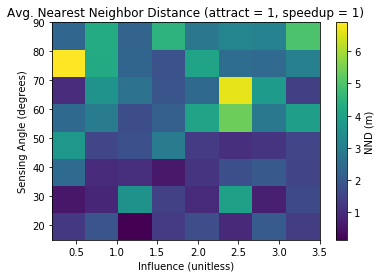

In [134]:
heatmap_plt_nnd(nnd_atr1_spe1, atr=1, su=1)